In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from tensorflow.keras.layers import Input, concatenate,Dense
from keras.models import Sequential
from keras.layers import Concatenate, Dense,Input, concatenate
from keras.models import Model    
from keras.layers import Dropout,Flatten
from sklearn.model_selection import KFold

In [2]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

#np.random.seed(4); #same set of numbers will appear every time
#np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.2*4000=800

# spatial slicing dimensions
os = 8 # output slice size
halo = 2 # edge cells
ts = os + halo * 2 # total input slice size including halos 12
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 511  # number of slices in one profile 



In [5]:
#spatial slicing the 4000 profiles 

image=np.zeros((l2r*num,ts,3)) 
label=np.zeros((l2r*num,os)) 

#cut each profile into 4066 slices. 
#label: tau channel of the center of each slice(reduced domain)
for i in range(num):
    for n in range(l2r):
        img= data[i,n*os:n*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
        lb = data[i,n*os+halo:n*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
        image[i*l2r+n]=img
        label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #4066*4000=16264000


whole dataset features size:  (2044000, 12, 3) whole dataset label size:  (2044000, 8)


In [6]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [7]:
# DNN over domain -------------------------------------------

def evaluate_model(train_image, test_image, train_label, test_label):

    input_img = Input(shape=(ts,nchan))
    hn=Flatten()(input_img)
    hn = Dense(8, activation='relu')(hn)#1st fully connected layer
    hn1 =Dense(1024, activation='relu')(hn)
    hn1=Dense(1024, activation='relu')(hn1)
    hn1=Dropout(0.5)(hn1)
    hn1=Dense(8, activation='relu')(hn1) #4th fully connected layer
    out_both = concatenate([hn, hn1], axis=1, name = 'concatenate')
    hn2=Dense(8, activation='linear')(out_both)
    model_m = Model(input_img, outputs=[hn2])
    model_m.summary()


    ltype = 'mean_squared_error'
    ltype2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 1024
    eps = 500

    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,ltype2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 25,restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------
    print('test result')

    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)

    mse = results[0]
    rmse=results[2]
    
    return model_m,rmse,mse,history,predictions

In [11]:
#5 folds cross validation 

n_folds=5
kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)
print('ratio:',ratio)
print('train folds:',ratio*4)

KFold(n_splits=5, random_state=None, shuffle=False)
ratio: 408800
train folds: 1635200


In [13]:
cv_scores= list()
cv_scores2=list()
model_history=list()

count=1
for train_index, test_index in kf.split(image):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_image, test_image = image[train_index], image[test_index]
    train_label, test_label = label[train_index], label[test_index]

    model_m,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(count)+' : '+str(mse))
    print('RMSE on test set in fold'+str(count)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

    count+=1
    

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12, 3)]      0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 36)           0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8)            296         flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1024)         9216        dense_5[0][0]                    
____________________________________________________________________________________________

Epoch 59/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.7243 - mean_squared_error: 14.7243 - root_mean_squared_error: 3.8370 - val_loss: 14.4807 - val_mean_squared_error: 14.4807 - val_root_mean_squared_error: 3.8054
Epoch 60/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.6617 - mean_squared_error: 14.6617 - root_mean_squared_error: 3.8289 - val_loss: 14.4359 - val_mean_squared_error: 14.4359 - val_root_mean_squared_error: 3.7995
Epoch 61/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.9181 - mean_squared_error: 14.9181 - root_mean_squared_error: 3.8623 - val_loss: 14.6672 - val_mean_squared_error: 14.6672 - val_root_mean_squared_error: 3.8298
Epoch 62/500
1398/1398 [==============================] - 8s 6ms/step - loss: 15.0275 - mean_squared_error: 15.0275 - root_mean_squared_error: 3.8762 - val_loss: 16.0506 - val_mean_squared_error: 16.0506 - val_root_mean_squared_error: 4.0063
Epoch 63/500
1398/1398 [========

Epoch 93/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.4824 - mean_squared_error: 14.4824 - root_mean_squared_error: 3.8052 - val_loss: 15.4475 - val_mean_squared_error: 15.4475 - val_root_mean_squared_error: 3.9303
Epoch 94/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.7605 - mean_squared_error: 14.7605 - root_mean_squared_error: 3.8415 - val_loss: 14.5036 - val_mean_squared_error: 14.5036 - val_root_mean_squared_error: 3.8084
Epoch 95/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.5395 - mean_squared_error: 14.5395 - root_mean_squared_error: 3.8129 - val_loss: 17.9435 - val_mean_squared_error: 17.9435 - val_root_mean_squared_error: 4.2360
Epoch 96/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.5793 - mean_squared_error: 14.5793 - root_mean_squared_error: 3.8181 - val_loss: 14.2811 - val_mean_squared_error: 14.2811 - val_root_mean_squared_error: 3.7790
Epoch 97/500
1398/1398 [========

Epoch 127/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.2259 - mean_squared_error: 14.2259 - root_mean_squared_error: 3.7717 - val_loss: 15.2221 - val_mean_squared_error: 15.2221 - val_root_mean_squared_error: 3.9016
Epoch 128/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.2391 - mean_squared_error: 14.2391 - root_mean_squared_error: 3.7732 - val_loss: 14.6161 - val_mean_squared_error: 14.6161 - val_root_mean_squared_error: 3.8231
Epoch 129/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1766 - mean_squared_error: 14.1766 - root_mean_squared_error: 3.7649 - val_loss: 14.1546 - val_mean_squared_error: 14.1546 - val_root_mean_squared_error: 3.7623
Epoch 130/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.9391 - mean_squared_error: 13.9391 - root_mean_squared_error: 3.7333 - val_loss: 14.2754 - val_mean_squared_error: 14.2754 - val_root_mean_squared_error: 3.7783
Epoch 131/500
1398/1398 [===

Epoch 161/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.7475 - mean_squared_error: 13.7475 - root_mean_squared_error: 3.7076 - val_loss: 13.5830 - val_mean_squared_error: 13.5830 - val_root_mean_squared_error: 3.6855
Epoch 162/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.6935 - mean_squared_error: 13.6935 - root_mean_squared_error: 3.7004 - val_loss: 13.7210 - val_mean_squared_error: 13.7210 - val_root_mean_squared_error: 3.7042
Epoch 163/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.5984 - mean_squared_error: 13.5984 - root_mean_squared_error: 3.6874 - val_loss: 13.6179 - val_mean_squared_error: 13.6179 - val_root_mean_squared_error: 3.6902
Epoch 164/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6136 - mean_squared_error: 13.6136 - root_mean_squared_error: 3.6896 - val_loss: 14.3772 - val_mean_squared_error: 14.3772 - val_root_mean_squared_error: 3.7917
Epoch 165/500
1398/1398 [===

Epoch 195/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.4686 - mean_squared_error: 13.4686 - root_mean_squared_error: 3.6698 - val_loss: 13.5969 - val_mean_squared_error: 13.5969 - val_root_mean_squared_error: 3.6874
Epoch 196/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.2719 - mean_squared_error: 13.2719 - root_mean_squared_error: 3.6429 - val_loss: 16.5038 - val_mean_squared_error: 16.5038 - val_root_mean_squared_error: 4.0625
Epoch 197/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3416 - mean_squared_error: 13.3416 - root_mean_squared_error: 3.6525 - val_loss: 13.5095 - val_mean_squared_error: 13.5095 - val_root_mean_squared_error: 3.6755
Epoch 198/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.5328 - mean_squared_error: 13.5328 - root_mean_squared_error: 3.6786 - val_loss: 13.8274 - val_mean_squared_error: 13.8274 - val_root_mean_squared_error: 3.7185
Epoch 199/500
1398/1398 [===

Epoch 229/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.3154 - mean_squared_error: 13.3154 - root_mean_squared_error: 3.6487 - val_loss: 13.3905 - val_mean_squared_error: 13.3905 - val_root_mean_squared_error: 3.6593
Epoch 230/500
1398/1398 [==============================] - 8s 6ms/step - loss: 13.1624 - mean_squared_error: 13.1624 - root_mean_squared_error: 3.6276 - val_loss: 13.1057 - val_mean_squared_error: 13.1057 - val_root_mean_squared_error: 3.6202
Epoch 231/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.2161 - mean_squared_error: 13.2161 - root_mean_squared_error: 3.6353 - val_loss: 12.7970 - val_mean_squared_error: 12.7970 - val_root_mean_squared_error: 3.5773
Epoch 232/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1532 - mean_squared_error: 13.1532 - root_mean_squared_error: 3.6266 - val_loss: 14.1121 - val_mean_squared_error: 14.1121 - val_root_mean_squared_error: 3.7566
Epoch 233/500
1398/1398 [===

Epoch 263/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.7953 - mean_squared_error: 12.7953 - root_mean_squared_error: 3.5768 - val_loss: 13.1179 - val_mean_squared_error: 13.1179 - val_root_mean_squared_error: 3.6219
Epoch 264/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.0005 - mean_squared_error: 13.0005 - root_mean_squared_error: 3.6055 - val_loss: 13.1918 - val_mean_squared_error: 13.1918 - val_root_mean_squared_error: 3.6321
Epoch 265/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.0237 - mean_squared_error: 13.0237 - root_mean_squared_error: 3.6088 - val_loss: 12.9650 - val_mean_squared_error: 12.9650 - val_root_mean_squared_error: 3.6007
Epoch 266/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.7698 - mean_squared_error: 12.7698 - root_mean_squared_error: 3.5732 - val_loss: 14.1346 - val_mean_squared_error: 14.1346 - val_root_mean_squared_error: 3.7596
Epoch 267/500
1398/1398 [===

Epoch 297/500
1398/1398 [==============================] - 8s 6ms/step - loss: 12.9512 - mean_squared_error: 12.9512 - root_mean_squared_error: 3.5986 - val_loss: 15.6116 - val_mean_squared_error: 15.6116 - val_root_mean_squared_error: 3.9511
Epoch 298/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.7616 - mean_squared_error: 12.7616 - root_mean_squared_error: 3.5721 - val_loss: 12.9682 - val_mean_squared_error: 12.9682 - val_root_mean_squared_error: 3.6011
Epoch 299/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.5208 - mean_squared_error: 12.5208 - root_mean_squared_error: 3.5381 - val_loss: 13.1632 - val_mean_squared_error: 13.1632 - val_root_mean_squared_error: 3.6281
Epoch 300/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.8672 - mean_squared_error: 12.8672 - root_mean_squared_error: 3.5869 - val_loss: 13.1885 - val_mean_squared_error: 13.1885 - val_root_mean_squared_error: 3.6316
Restoring model weights from

Epoch 20/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.5997 - mean_squared_error: 14.5997 - root_mean_squared_error: 3.8209 - val_loss: 16.7897 - val_mean_squared_error: 16.7897 - val_root_mean_squared_error: 4.0975
Epoch 21/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.4235 - mean_squared_error: 14.4235 - root_mean_squared_error: 3.7977 - val_loss: 14.4635 - val_mean_squared_error: 14.4635 - val_root_mean_squared_error: 3.8031
Epoch 22/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.5239 - mean_squared_error: 14.5239 - root_mean_squared_error: 3.8108 - val_loss: 14.3452 - val_mean_squared_error: 14.3452 - val_root_mean_squared_error: 3.7875
Epoch 23/500
1398/1398 [==============================] - 8s 6ms/step - loss: 14.3813 - mean_squared_error: 14.3813 - root_mean_squared_error: 3.7922 - val_loss: 14.9345 - val_mean_squared_error: 14.9345 - val_root_mean_squared_error: 3.8645
Epoch 24/500
1398/1398 [========

Epoch 54/500
1398/1398 [==============================] - 8s 6ms/step - loss: 13.7221 - mean_squared_error: 13.7221 - root_mean_squared_error: 3.7041 - val_loss: 13.9803 - val_mean_squared_error: 13.9803 - val_root_mean_squared_error: 3.7390
Epoch 55/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.9659 - mean_squared_error: 13.9659 - root_mean_squared_error: 3.7369 - val_loss: 14.0392 - val_mean_squared_error: 14.0392 - val_root_mean_squared_error: 3.7469
Epoch 56/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.7593 - mean_squared_error: 13.7593 - root_mean_squared_error: 3.7092 - val_loss: 13.7666 - val_mean_squared_error: 13.7666 - val_root_mean_squared_error: 3.7103
Epoch 57/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.6929 - mean_squared_error: 13.6929 - root_mean_squared_error: 3.7000 - val_loss: 13.5620 - val_mean_squared_error: 13.5620 - val_root_mean_squared_error: 3.6827
Epoch 58/500
1398/1398 [========

Epoch 88/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9888 - mean_squared_error: 12.9888 - root_mean_squared_error: 3.6038 - val_loss: 13.3622 - val_mean_squared_error: 13.3622 - val_root_mean_squared_error: 3.6554
Epoch 89/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.8899 - mean_squared_error: 12.8899 - root_mean_squared_error: 3.5902 - val_loss: 13.1584 - val_mean_squared_error: 13.1584 - val_root_mean_squared_error: 3.6274
Epoch 90/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9879 - mean_squared_error: 12.9879 - root_mean_squared_error: 3.6037 - val_loss: 13.1200 - val_mean_squared_error: 13.1200 - val_root_mean_squared_error: 3.6222
Epoch 91/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9010 - mean_squared_error: 12.9010 - root_mean_squared_error: 3.5917 - val_loss: 13.5181 - val_mean_squared_error: 13.5181 - val_root_mean_squared_error: 3.6767
Epoch 92/500
1398/1398 [========

Epoch 122/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.3342 - mean_squared_error: 12.3342 - root_mean_squared_error: 3.5118 - val_loss: 12.2871 - val_mean_squared_error: 12.2871 - val_root_mean_squared_error: 3.5053
Epoch 123/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.5612 - mean_squared_error: 12.5612 - root_mean_squared_error: 3.5438 - val_loss: 12.9741 - val_mean_squared_error: 12.9741 - val_root_mean_squared_error: 3.6020
Epoch 124/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3546 - mean_squared_error: 12.3546 - root_mean_squared_error: 3.5148 - val_loss: 13.3544 - val_mean_squared_error: 13.3544 - val_root_mean_squared_error: 3.6544
Epoch 125/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3484 - mean_squared_error: 13.3484 - root_mean_squared_error: 3.6529 - val_loss: 12.9003 - val_mean_squared_error: 12.9003 - val_root_mean_squared_error: 3.5917
Epoch 126/500
1398/1398 [===

Epoch 156/500
1398/1398 [==============================] - 8s 6ms/step - loss: 12.1547 - mean_squared_error: 12.1547 - root_mean_squared_error: 3.4863 - val_loss: 12.5428 - val_mean_squared_error: 12.5428 - val_root_mean_squared_error: 3.5416
Epoch 157/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.2134 - mean_squared_error: 12.2134 - root_mean_squared_error: 3.4946 - val_loss: 12.0981 - val_mean_squared_error: 12.0981 - val_root_mean_squared_error: 3.4782
Epoch 158/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.1309 - mean_squared_error: 12.1309 - root_mean_squared_error: 3.4828 - val_loss: 11.9950 - val_mean_squared_error: 11.9950 - val_root_mean_squared_error: 3.4634
Epoch 159/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.0947 - mean_squared_error: 12.0947 - root_mean_squared_error: 3.4775 - val_loss: 12.4976 - val_mean_squared_error: 12.4976 - val_root_mean_squared_error: 3.5352
Epoch 160/500
1398/1398 [===

Epoch 190/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.1118 - mean_squared_error: 12.1118 - root_mean_squared_error: 3.4800 - val_loss: 11.7544 - val_mean_squared_error: 11.7544 - val_root_mean_squared_error: 3.4285
Epoch 191/500
1398/1398 [==============================] - 8s 5ms/step - loss: 11.9382 - mean_squared_error: 11.9382 - root_mean_squared_error: 3.4544 - val_loss: 12.1855 - val_mean_squared_error: 12.1855 - val_root_mean_squared_error: 3.4908
Epoch 192/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.0009 - mean_squared_error: 12.0009 - root_mean_squared_error: 3.4641 - val_loss: 12.0506 - val_mean_squared_error: 12.0506 - val_root_mean_squared_error: 3.4714
Epoch 193/500
1398/1398 [==============================] - 8s 5ms/step - loss: 11.9433 - mean_squared_error: 11.9433 - root_mean_squared_error: 3.4557 - val_loss: 14.0055 - val_mean_squared_error: 14.0055 - val_root_mean_squared_error: 3.7424
Epoch 194/500
1398/1398 [===

Epoch 224/500
1398/1398 [==============================] - 8s 5ms/step - loss: 11.9263 - mean_squared_error: 11.9263 - root_mean_squared_error: 3.4532 - val_loss: 11.8797 - val_mean_squared_error: 11.8797 - val_root_mean_squared_error: 3.4467
Epoch 225/500
1398/1398 [==============================] - 8s 6ms/step - loss: 11.6448 - mean_squared_error: 11.6448 - root_mean_squared_error: 3.4122 - val_loss: 13.4443 - val_mean_squared_error: 13.4443 - val_root_mean_squared_error: 3.6666
Restoring model weights from the end of the best epoch.
Epoch 00225: early stopping
test result
12775/12775 [==============================] - 29s 2ms/step - loss: 11.9673 - mean_squared_error: 11.9673 - root_mean_squared_error: 3.4594
MSE on test set in fold2 : 11.967257499694824
RMSE on test set in fold2 : 3.4593725204467773
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Conn

Epoch 22/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.8767 - mean_squared_error: 14.8767 - root_mean_squared_error: 3.8569 - val_loss: 17.8158 - val_mean_squared_error: 17.8158 - val_root_mean_squared_error: 4.2209
Epoch 23/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.9895 - mean_squared_error: 14.9895 - root_mean_squared_error: 3.8714 - val_loss: 14.5835 - val_mean_squared_error: 14.5835 - val_root_mean_squared_error: 3.8188
Epoch 24/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.7785 - mean_squared_error: 14.7785 - root_mean_squared_error: 3.8442 - val_loss: 16.0806 - val_mean_squared_error: 16.0806 - val_root_mean_squared_error: 4.0101
Epoch 25/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.7740 - mean_squared_error: 14.7740 - root_mean_squared_error: 3.8436 - val_loss: 14.7637 - val_mean_squared_error: 14.7637 - val_root_mean_squared_error: 3.8424
Epoch 26/500
1398/1398 [========

Epoch 56/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9322 - mean_squared_error: 13.9322 - root_mean_squared_error: 3.7325 - val_loss: 13.8899 - val_mean_squared_error: 13.8899 - val_root_mean_squared_error: 3.7269
Epoch 57/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9815 - mean_squared_error: 13.9815 - root_mean_squared_error: 3.7391 - val_loss: 14.2740 - val_mean_squared_error: 14.2740 - val_root_mean_squared_error: 3.7781
Epoch 58/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.0823 - mean_squared_error: 14.0823 - root_mean_squared_error: 3.7525 - val_loss: 13.9349 - val_mean_squared_error: 13.9349 - val_root_mean_squared_error: 3.7329
Epoch 59/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1903 - mean_squared_error: 14.1903 - root_mean_squared_error: 3.7668 - val_loss: 14.3042 - val_mean_squared_error: 14.3042 - val_root_mean_squared_error: 3.7821
Epoch 60/500
1398/1398 [========

Epoch 90/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.7625 - mean_squared_error: 13.7625 - root_mean_squared_error: 3.7095 - val_loss: 13.5412 - val_mean_squared_error: 13.5412 - val_root_mean_squared_error: 3.6798
Epoch 91/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6727 - mean_squared_error: 13.6727 - root_mean_squared_error: 3.6975 - val_loss: 13.5012 - val_mean_squared_error: 13.5012 - val_root_mean_squared_error: 3.6744
Epoch 92/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6010 - mean_squared_error: 13.6010 - root_mean_squared_error: 3.6877 - val_loss: 13.7088 - val_mean_squared_error: 13.7088 - val_root_mean_squared_error: 3.7025
Epoch 93/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6079 - mean_squared_error: 13.6079 - root_mean_squared_error: 3.6888 - val_loss: 14.1362 - val_mean_squared_error: 14.1362 - val_root_mean_squared_error: 3.7598
Epoch 94/500
1398/1398 [========

Epoch 124/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4445 - mean_squared_error: 13.4445 - root_mean_squared_error: 3.6666 - val_loss: 15.2853 - val_mean_squared_error: 15.2853 - val_root_mean_squared_error: 3.9096
Epoch 125/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4986 - mean_squared_error: 13.4986 - root_mean_squared_error: 3.6740 - val_loss: 13.3332 - val_mean_squared_error: 13.3332 - val_root_mean_squared_error: 3.6515
Epoch 126/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4186 - mean_squared_error: 13.4186 - root_mean_squared_error: 3.6628 - val_loss: 13.3922 - val_mean_squared_error: 13.3922 - val_root_mean_squared_error: 3.6595
Epoch 127/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4086 - mean_squared_error: 13.4086 - root_mean_squared_error: 3.6617 - val_loss: 13.5429 - val_mean_squared_error: 13.5429 - val_root_mean_squared_error: 3.6801
Epoch 128/500
1398/1398 [===

Epoch 158/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1070 - mean_squared_error: 13.1070 - root_mean_squared_error: 3.6202 - val_loss: 13.7430 - val_mean_squared_error: 13.7430 - val_root_mean_squared_error: 3.7072
Epoch 159/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.7903 - mean_squared_error: 12.7903 - root_mean_squared_error: 3.5762 - val_loss: 12.9399 - val_mean_squared_error: 12.9399 - val_root_mean_squared_error: 3.5972
Epoch 160/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9075 - mean_squared_error: 12.9075 - root_mean_squared_error: 3.5926 - val_loss: 12.5925 - val_mean_squared_error: 12.5925 - val_root_mean_squared_error: 3.5486
Epoch 161/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9624 - mean_squared_error: 12.9624 - root_mean_squared_error: 3.6001 - val_loss: 14.9130 - val_mean_squared_error: 14.9130 - val_root_mean_squared_error: 3.8617
Epoch 162/500
1398/1398 [===

Epoch 192/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.2693 - mean_squared_error: 12.2693 - root_mean_squared_error: 3.5026 - val_loss: 12.9812 - val_mean_squared_error: 12.9812 - val_root_mean_squared_error: 3.6029
Epoch 193/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.6218 - mean_squared_error: 12.6218 - root_mean_squared_error: 3.5525 - val_loss: 12.5066 - val_mean_squared_error: 12.5066 - val_root_mean_squared_error: 3.5365
Epoch 194/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.5767 - mean_squared_error: 12.5767 - root_mean_squared_error: 3.5463 - val_loss: 13.2590 - val_mean_squared_error: 13.2590 - val_root_mean_squared_error: 3.6413
Epoch 195/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.4580 - mean_squared_error: 12.4580 - root_mean_squared_error: 3.5294 - val_loss: 13.1166 - val_mean_squared_error: 13.1166 - val_root_mean_squared_error: 3.6217
Epoch 196/500
1398/1398 [===

Epoch 226/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.2667 - mean_squared_error: 12.2667 - root_mean_squared_error: 3.5023 - val_loss: 12.8522 - val_mean_squared_error: 12.8522 - val_root_mean_squared_error: 3.5850
Epoch 227/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3516 - mean_squared_error: 12.3516 - root_mean_squared_error: 3.5143 - val_loss: 12.4399 - val_mean_squared_error: 12.4399 - val_root_mean_squared_error: 3.5270
Epoch 228/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.1119 - mean_squared_error: 12.1119 - root_mean_squared_error: 3.4799 - val_loss: 12.3422 - val_mean_squared_error: 12.3422 - val_root_mean_squared_error: 3.5131
Epoch 229/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3607 - mean_squared_error: 12.3607 - root_mean_squared_error: 3.5157 - val_loss: 12.2621 - val_mean_squared_error: 12.2621 - val_root_mean_squared_error: 3.5017
Epoch 230/500
1398/1398 [===

1398/1398 [==============================] - 8s 5ms/step - loss: 39.7139 - mean_squared_error: 39.7139 - root_mean_squared_error: 6.1765 - val_loss: 21.7703 - val_mean_squared_error: 21.7703 - val_root_mean_squared_error: 4.6659
Epoch 2/500
1398/1398 [==============================] - 7s 5ms/step - loss: 21.0253 - mean_squared_error: 21.0253 - root_mean_squared_error: 4.5852 - val_loss: 21.1545 - val_mean_squared_error: 21.1545 - val_root_mean_squared_error: 4.5994
Epoch 3/500
1398/1398 [==============================] - 7s 5ms/step - loss: 20.9718 - mean_squared_error: 20.9718 - root_mean_squared_error: 4.5794 - val_loss: 21.4388 - val_mean_squared_error: 21.4388 - val_root_mean_squared_error: 4.6302
Epoch 4/500
1398/1398 [==============================] - 7s 5ms/step - loss: 20.6288 - mean_squared_error: 20.6288 - root_mean_squared_error: 4.5418 - val_loss: 21.4191 - val_mean_squared_error: 21.4191 - val_root_mean_squared_error: 4.6281
Epoch 5/500
1398/1398 [=========================

Epoch 35/500
1398/1398 [==============================] - 7s 5ms/step - loss: 15.0171 - mean_squared_error: 15.0171 - root_mean_squared_error: 3.8750 - val_loss: 15.4124 - val_mean_squared_error: 15.4124 - val_root_mean_squared_error: 3.9259
Epoch 36/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.9577 - mean_squared_error: 14.9577 - root_mean_squared_error: 3.8675 - val_loss: 15.0345 - val_mean_squared_error: 15.0345 - val_root_mean_squared_error: 3.8774
Epoch 37/500
1398/1398 [==============================] - 8s 5ms/step - loss: 15.0467 - mean_squared_error: 15.0467 - root_mean_squared_error: 3.8789 - val_loss: 14.8207 - val_mean_squared_error: 14.8207 - val_root_mean_squared_error: 3.8498
Epoch 38/500
1398/1398 [==============================] - 7s 5ms/step - loss: 15.0994 - mean_squared_error: 15.0994 - root_mean_squared_error: 3.8857 - val_loss: 15.4410 - val_mean_squared_error: 15.4410 - val_root_mean_squared_error: 3.9295
Epoch 39/500
1398/1398 [========

Epoch 8/500
1398/1398 [==============================] - 7s 5ms/step - loss: 17.3691 - mean_squared_error: 17.3691 - root_mean_squared_error: 4.1675 - val_loss: 17.4585 - val_mean_squared_error: 17.4585 - val_root_mean_squared_error: 4.1783
Epoch 9/500
1398/1398 [==============================] - 7s 5ms/step - loss: 16.4522 - mean_squared_error: 16.4522 - root_mean_squared_error: 4.0560 - val_loss: 16.2763 - val_mean_squared_error: 16.2763 - val_root_mean_squared_error: 4.0344
Epoch 10/500
1398/1398 [==============================] - 7s 5ms/step - loss: 16.0506 - mean_squared_error: 16.0506 - root_mean_squared_error: 4.0062 - val_loss: 15.1370 - val_mean_squared_error: 15.1370 - val_root_mean_squared_error: 3.8906
Epoch 11/500
1398/1398 [==============================] - 7s 5ms/step - loss: 15.8036 - mean_squared_error: 15.8036 - root_mean_squared_error: 3.9751 - val_loss: 15.3748 - val_mean_squared_error: 15.3748 - val_root_mean_squared_error: 3.9211
Epoch 12/500
1398/1398 [==========

Epoch 42/500
1398/1398 [==============================] - 8s 6ms/step - loss: 14.6262 - mean_squared_error: 14.6262 - root_mean_squared_error: 3.8240 - val_loss: 14.0532 - val_mean_squared_error: 14.0532 - val_root_mean_squared_error: 3.7488
Epoch 43/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1313 - mean_squared_error: 14.1313 - root_mean_squared_error: 3.7591 - val_loss: 13.6197 - val_mean_squared_error: 13.6197 - val_root_mean_squared_error: 3.6905
Epoch 44/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.0990 - mean_squared_error: 14.0990 - root_mean_squared_error: 3.7547 - val_loss: 13.5716 - val_mean_squared_error: 13.5716 - val_root_mean_squared_error: 3.6840
Epoch 45/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.1995 - mean_squared_error: 14.1995 - root_mean_squared_error: 3.7681 - val_loss: 13.5219 - val_mean_squared_error: 13.5219 - val_root_mean_squared_error: 3.6772
Epoch 46/500
1398/1398 [========

Epoch 76/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7882 - mean_squared_error: 13.7882 - root_mean_squared_error: 3.7131 - val_loss: 13.5596 - val_mean_squared_error: 13.5596 - val_root_mean_squared_error: 3.6823
Epoch 77/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.0255 - mean_squared_error: 14.0255 - root_mean_squared_error: 3.7449 - val_loss: 13.8495 - val_mean_squared_error: 13.8495 - val_root_mean_squared_error: 3.7215
Epoch 78/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7962 - mean_squared_error: 13.7962 - root_mean_squared_error: 3.7142 - val_loss: 13.2650 - val_mean_squared_error: 13.2650 - val_root_mean_squared_error: 3.6421
Epoch 79/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7062 - mean_squared_error: 13.7062 - root_mean_squared_error: 3.7022 - val_loss: 14.3136 - val_mean_squared_error: 14.3136 - val_root_mean_squared_error: 3.7833
Epoch 80/500
1398/1398 [========

Epoch 110/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.5715 - mean_squared_error: 13.5715 - root_mean_squared_error: 3.6838 - val_loss: 12.8312 - val_mean_squared_error: 12.8312 - val_root_mean_squared_error: 3.5821
Epoch 111/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3946 - mean_squared_error: 13.3946 - root_mean_squared_error: 3.6597 - val_loss: 13.6779 - val_mean_squared_error: 13.6779 - val_root_mean_squared_error: 3.6984
Epoch 112/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3266 - mean_squared_error: 13.3266 - root_mean_squared_error: 3.6504 - val_loss: 15.6847 - val_mean_squared_error: 15.6847 - val_root_mean_squared_error: 3.9604
Epoch 113/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4968 - mean_squared_error: 13.4968 - root_mean_squared_error: 3.6736 - val_loss: 12.8072 - val_mean_squared_error: 12.8072 - val_root_mean_squared_error: 3.5787
Epoch 114/500
1398/1398 [===

Epoch 144/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9891 - mean_squared_error: 12.9891 - root_mean_squared_error: 3.6039 - val_loss: 13.8392 - val_mean_squared_error: 13.8392 - val_root_mean_squared_error: 3.7201
Epoch 145/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1246 - mean_squared_error: 13.1246 - root_mean_squared_error: 3.6225 - val_loss: 14.2966 - val_mean_squared_error: 14.2966 - val_root_mean_squared_error: 3.7811
Epoch 146/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1138 - mean_squared_error: 13.1138 - root_mean_squared_error: 3.6209 - val_loss: 12.5337 - val_mean_squared_error: 12.5337 - val_root_mean_squared_error: 3.5403
Epoch 147/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9072 - mean_squared_error: 12.9072 - root_mean_squared_error: 3.5925 - val_loss: 12.4632 - val_mean_squared_error: 12.4632 - val_root_mean_squared_error: 3.5303
Epoch 148/500
1398/1398 [===

Epoch 178/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.7890 - mean_squared_error: 12.7890 - root_mean_squared_error: 3.5758 - val_loss: 11.9996 - val_mean_squared_error: 11.9996 - val_root_mean_squared_error: 3.4640
Epoch 179/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.6768 - mean_squared_error: 12.6768 - root_mean_squared_error: 3.5603 - val_loss: 13.5112 - val_mean_squared_error: 13.5112 - val_root_mean_squared_error: 3.6758
Epoch 180/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3253 - mean_squared_error: 12.3253 - root_mean_squared_error: 3.5106 - val_loss: 11.9142 - val_mean_squared_error: 11.9142 - val_root_mean_squared_error: 3.4517
Epoch 181/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.4110 - mean_squared_error: 12.4110 - root_mean_squared_error: 3.5227 - val_loss: 15.3792 - val_mean_squared_error: 15.3792 - val_root_mean_squared_error: 3.9216
Epoch 182/500
1398/1398 [===

Epoch 212/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.4023 - mean_squared_error: 12.4023 - root_mean_squared_error: 3.5216 - val_loss: 11.8138 - val_mean_squared_error: 11.8138 - val_root_mean_squared_error: 3.4371
Epoch 213/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.4670 - mean_squared_error: 12.4670 - root_mean_squared_error: 3.5308 - val_loss: 12.1411 - val_mean_squared_error: 12.1411 - val_root_mean_squared_error: 3.4844
Epoch 214/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.2998 - mean_squared_error: 12.2998 - root_mean_squared_error: 3.5070 - val_loss: 11.9815 - val_mean_squared_error: 11.9815 - val_root_mean_squared_error: 3.4614
Epoch 215/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3426 - mean_squared_error: 12.3426 - root_mean_squared_error: 3.5132 - val_loss: 12.2026 - val_mean_squared_error: 12.2026 - val_root_mean_squared_error: 3.4932
Epoch 216/500
1398/1398 [===

In [15]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 12.4160 with standard deviation (0.7574)
Estimated RMSE 3.5221 with standard deviation (0.1056)


In [16]:
cv_scores2

[3.521357297897339,
 3.4593725204467773,
 3.4290738105773926,
 3.7246410846710205,
 3.47583270072937]

In [17]:
cv_scores

[12.399955749511719,
 11.967257499694824,
 11.758546829223633,
 13.87295150756836,
 12.081412315368652]

In [18]:
predictions.shape

(408800, 8)

The optimal number of epochs is 204


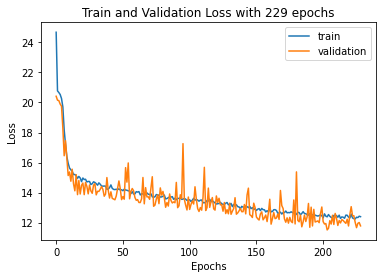

In [19]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))